In [1]:
import os
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
import fitz # From PyMuPDF
from PIL import Image
import cv2
import argparse
import imutils
import sys

In [2]:
def pdf_to_png(pdf_name, pdf_dir, png_dir, debug=False):
    # Erase ".pdf" in case it is in the name
    pdf_name = pdf_name.replace('.pdf','')
    
    # Open the pdf
    doc = fitz.open(f'{pdf_dir}{pdf_name}.pdf')
    page = doc[0]
    
    # Transform the page into an image
    img = doc.getPageImageList(0)[0]
    xref = img[0]
    pix = fitz.Pixmap(doc, xref)
    
    # Create the png name
    png_name = f'{png_dir}{pdf_name}.png'
    
    # Saves the pdf as a png image
    if pix.n < 5:       # this is GRAY or RGB
        pix.writePNG(png_name)
    else:               # CMYK: convert to RGB first
        pix1 = fitz.Pixmap(fitz.csRGB, pix)
        pix1.writePNG(png_name)
        pix1 = None
    pix = None
    
    if debug:
        print(f'Image {png_name} was saved')
    
    return png_name

In [3]:
os.chdir(r'D:\Dropbox\Proyectos\python\formatos_elecciones')
pdf_list = [x for i,x in enumerate(os.listdir('test')) if '.pdf' in x]

1. Leer el PDF y pasarlo a png

In [4]:
dep = '11'
mun = '4'
zona = '99'
x = '3141411_E14_PRE_X_11_004_099_XX_17_003_X_XXX'

In [5]:
png_name = pdf_to_png(x, f'formularios_e_14/{dep}/{mun}/{zona}/', 'test/')
orig_img = cv2.imread(f'{png_name}')

<img src="D:/Dropbox/Proyectos/python/formatos_elecciones/test/3141411_E14_PRE_X_11_004_099_XX_17_003_X_XXX.png" alt="Drawing" style="width: 400px;"/>

2. Encontrar los cuatro rectangulos que limitan la tabla con el conteo de votos

In [95]:
# Transform the morphology of the image to end up with only the darker parts
se = np.ones((7,7), dtype='uint8')
img = cv2.morphologyEx(orig_img, cv2.MORPH_CLOSE, se)
cv2.imwrite('test/morph.png', img)

# Transform to gray
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2.imwrite('test/gray.png', gray)

# Apply threshold
thresh = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)[1]
cv2.imwrite('test/thresh.png', thresh)

True

<img src="D:/Dropbox/Proyectos/python/formatos_elecciones/test/morph.png" alt="Drawing" style="width: 400px;"/>

In [96]:
# Find contours
contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
orig_img_cont = orig_img
cv2.drawContours(orig_img_cont, contours, -1, (0, 255, 0), 2) 
len(contours)
cv2.imwrite('test/contours.png', orig_img_cont)

True

<img src="test/contours.png" alt="Drawing" style="width: 400px;"/>

In [82]:
# Define the general size of the squares we are looking for
rect_size = 32*26
#w_h_ratio = 31/26
buffer = 200

# Calculate area of the contours and keep only those between the range desired
area = [cv2.contourArea(c) for c in contours]

# Find the position of the chosen contours in the contour list
area_pos = [i for i, x in enumerate(area) if (rect_size + buffer) > x > (rect_size - buffer)]

# Width and height of the image
height, width, channels = img.shape

In [83]:
# Save coordinates of the whole box we want
x0 = width
x1 = 0
y0 = height
y1 = 0

center = (width/2, height/2)

# Empty list to save our squares
rect_list = []

# Find which of the contours of correct size are closer to the shape we want
for i,pos in enumerate(area_pos):
    cont = contours[pos]

    # Find the polynomial aproximation of the contours in order to 
    # find which resemble more a rectangle of the size we want
    approx = cv2.approxPolyDP(cont,0.025*cv2.arcLength(cont,True),True)

    # If there are 4 elements in approx, it is a rectangle or square
    if len(approx) == 4:
        (x, y, w, h) = cv2.boundingRect(approx)

        if (1.3 > w/h > 0.7) & (2000 > y > 400):

            rect_list += [(x, y, w, h)]

            # We save the highest and lowest value of the (x,y) coordinates each
            # iteration so we know the overall bounding box of the table.
            x0 = min(x, x0)
            x1 = max(x + w, x1)

            y0 = min(y, y0)
            y1 = max(y + h, y1)

            # Before this we saved the top left corner of the bottom right square
            # so we need to go to the lower right corner of this square to have
            # the correct area.
            if (x == x1) & (y == y1):
                x1 = x + w
                y1 = y + h         

            # Find the triangle corners to calculate the rotation angle 
            cx, cy = ((x + w/2),(y + h/2))

            if (cx < center[0]) & (cy < center[1]):
                cor_1 = (x,y)
                cen_1 = (cx,cy)
            elif (cx > center[0]) & (cy < center[1]):
                cor_2 = (x,y)
                cen_2 = (cx,cy)
            elif (cx > center[0]) & (cy > center[1]):
                cor_3 = (x,y)
                cen_3 = (cx,cy)
            elif (cx < center[0]) & (cy > center[1]):
                cor_4 = (x,y)
                cen_4 = (cx,cy)

corner_1 = cor_1

if cen_1[1] <= cen_2[1]:    
    corner_2 = cor_2
else:
    corner_2 = cor_4
cv2.imwrite('test/approx_poly.png', orig_img)

True

<img src="test/approx_poly.png" alt="Drawing" style="width: 400px;"/>

In [84]:
crop_img = orig_img[y0:y1,x0:x1]
cv2.imwrite('test/crop_img.png', crop_img)

True

<img src="test/crop_img.png" alt="Drawing" style="width: 400px;"/>

3. Rotar la imagen

In [85]:
# Width and height of the image
height, width = img.shape[:2]

# Find the angle to rotate the image
np.seterr('ignore')
# Calculate sides a and b of the trinangle
a = abs(corner_1[1] - corner_2[1])
b = abs(corner_2[0] - corner_1[0])
# Calculate the hipotenuse
c = np.sqrt(a**2 + b**2)
# Calculate the angles of the triangle. They give the rotation angle
A = np.degrees(np.arcsin(a/c))
B = np.degrees(np.arcsin(b/c))

# If the triangle is wider than it is tall, the rotation must be clockwise
# if it is taller than it is wide, the rotation must be counterclockwise
if (a - b) < 0 :
    angle = min(A,30)
else:
    angle = -min(B,30)

img_center = tuple(np.array([width, height]) / 2)
rot_mat = cv2.getRotationMatrix2D(img_center, angle, 1.0)

# rotation calculates the cos and sin, taking absolutes of those.
abs_cos = abs(rot_mat[0,0]) 
abs_sin = abs(rot_mat[0,1])

# find the new width and height bounds
bound_w = int(height * abs_sin + width * abs_cos)
bound_h = int(height * abs_cos + width * abs_sin)

# subtract old image center (bringing image back to origo) and adding the new image center coordinates
rot_mat[0, 2] += bound_w/2 - img_center[0]
rot_mat[1, 2] += bound_h/2 - img_center[1]

# rotate image with the new bounds and translated rotation matrix

rot_img = cv2.warpAffine(orig_img, rot_mat,  (bound_w, bound_h), flags=cv2.INTER_LINEAR)

cv2.imwrite('test/rotated.png', rot_img)

True

<img src="test/rotated.png" alt="Drawing" style="width: 400px;"/>

4. Encontrar los nuevos límites los rectángulos que limitan la tabla

In [86]:
rect_list

[(49, 1711, 32, 28),
 (793, 1707, 33, 28),
 (44, 586, 33, 27),
 (789, 584, 33, 27)]

In [87]:
# Save coordinates of the whole box we want
nheight, nwidth = img.shape[:2]

nx0 = nwidth
nx1 = 0
ny0 = nheight
ny1 = 0

for i,x in enumerate(rect_list):
    x_y_array = np.array(x[:2] + (1,))
    trans_x_y = rot_mat.dot(x_y_array)

    nx, ny, nw, nh = (int(np.round(trans_x_y[0])),
                      int(np.round(trans_x_y[1])),
                      x[2], x[3])
    # We save the highest and lowest value of the (x,y) coordinates each
    # iteration so we know the overall bounding box of the table.
    nx0 = min(nx, nx0)
    nx1 = max(nx + nw, nx1)

    ny0 = min(ny, ny0)
    ny1 = max(ny + nh, ny1)

    # Before this we saved the top left corner of the bottom right square
    # so we need to go to the lower right corner of this square to have
    # the correct area.
    if (nx == nx1) & (ny == ny1):
        nx1 = nx + nw
        ny1 = ny + nh

In [88]:
crop_rotated = rot_img[ny0:ny1,nx0:nx1]
cv2.imwrite('test/crop_rotated.png', crop_rotated)

True

<img src="test/crop_rotated.png" alt="Drawing" style="width: 400px;"/>

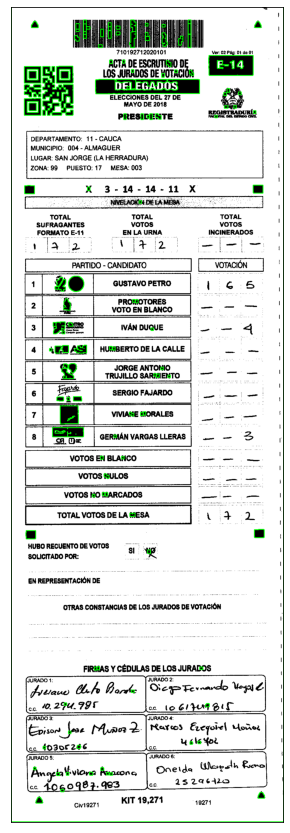

In [97]:
plt.figure(figsize=(15, 15))
plt.imshow(orig_img)
plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
plt.show()

<Figure size 1080x1080 with 0 Axes>

---
---

In [ ]:
x = '6399510_E14_PRE_X_28_160_000_XX_00_026_X_XXX'

In [ ]:
png_name = pdf_to_png(x, pdf_dir, 'test/')
orig_img = cv2.imread(f'{png_name}')

<img src="test/6399510_E14_PRE_X_28_160_000_XX_00_026_X_XXX.png" alt="Drawing" style="width: 400px;"/>

2. Encontrar los cuatro rectangulos que limitan la tabla con el conteo de votos

In [ ]:
# Transform the morphology of the image to end up with only the darker parts
se = np.ones((7,7), dtype='uint8')
img = cv2.morphologyEx(orig_img, cv2.MORPH_CLOSE, se)
cv2.imwrite('test/morph.png', img)

# Transform to gray
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2.imwrite('test/gray.png', gray)

# Apply threshold
thresh = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)[1]
cv2.imwrite('test/thresh.png', thresh)

<img src="test/morph.png" alt="Drawing" style="width: 400px;"/>

In [ ]:
# Find contours
contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
cv2.drawContours(orig_img, contours, -1, (0, 255, 0), 2) 
len(contours)
cv2.imwrite('test/contours.png', orig_img)

<img src="test/contours.png" alt="Drawing" style="width: 400px;"/>

In [ ]:
# Define the general size of the squares we are looking for
rect_size = 32*26
#w_h_ratio = 31/26
buffer = 200

# Calculate area of the contours and keep only those between the range desired
area = [cv2.contourArea(c) for c in contours]

# Find the position of the chosen contours in the contour list
area_pos = [i for i, x in enumerate(area) if (rect_size + buffer) > x > (rect_size - buffer)]

# Width and height of the image
height, width, channels = img.shape

In [ ]:
# Save coordinates of the whole box we want
x0 = width
x1 = 0
y0 = height
y1 = 0

center = (width/2, height/2)

# Empty list to save our squares
rect_list = []

# Find which of the contours of correct size are closer to the shape we want
for i,pos in enumerate(area_pos):
    cont = contours[pos]

    # Find the polynomial aproximation of the contours in order to 
    # find which resemble more a rectangle of the size we want
    approx = cv2.approxPolyDP(cont,0.025*cv2.arcLength(cont,True),True)

    # If there are 4 elements in approx, it is a rectangle or square
    if len(approx) == 4:
        (x, y, w, h) = cv2.boundingRect(approx)

        if (1.3 > w/h > 0.7) & (2000 > y > 400):

            rect_list += [(x, y, w, h)]

            # We save the highest and lowest value of the (x,y) coordinates each
            # iteration so we know the overall bounding box of the table.
            x0 = min(x, x0)
            x1 = max(x + w, x1)

            y0 = min(y, y0)
            y1 = max(y + h, y1)

            # Before this we saved the top left corner of the bottom right square
            # so we need to go to the lower right corner of this square to have
            # the correct area.
            if (x == x1) & (y == y1):
                x1 = x + w
                y1 = y + h         

            # Find the triangle corners to calculate the rotation angle 
            cx, cy = ((x + w/2),(y + h/2))

            if (cx < center[0]) & (cy < center[1]):
                cor_1 = (x,y)
                cen_1 = (cx,cy)
            elif (cx > center[0]) & (cy < center[1]):
                cor_2 = (x,y)
                cen_2 = (cx,cy)
            elif (cx > center[0]) & (cy > center[1]):
                cor_3 = (x,y)
                cen_3 = (cx,cy)
            elif (cx < center[0]) & (cy > center[1]):
                cor_4 = (x,y)
                cen_4 = (cx,cy)

corner_1 = cor_1

if cen_1[1] <= cen_2[1]:    
    corner_2 = cor_2
else:
    corner_2 = cor_4
cv2.imwrite('test/approx_poly.png', orig_img)

<img src="test/approx_poly.png" alt="Drawing" style="width: 400px;"/>

In [ ]:
crop_img = orig_img[y0:y1,x0:x1]
cv2.imwrite('test/crop_img.png', crop_img)

<img src="test/crop_img.png" alt="Drawing" style="width: 400px;"/>

3. Rotar la imagen

In [ ]:
# Width and height of the image
height, width = img.shape[:2]

# Find the angle to rotate the image
np.seterr('ignore')
# Calculate sides a and b of the trinangle
a = abs(corner_1[1] - corner_2[1])
b = abs(corner_2[0] - corner_1[0])
# Calculate the hipotenuse
c = np.sqrt(a**2 + b**2)
# Calculate the angles of the triangle. They give the rotation angle
A = np.degrees(np.arcsin(a/c))
B = np.degrees(np.arcsin(b/c))

# If the triangle is wider than it is tall, the rotation must be clockwise
# if it is taller than it is wide, the rotation must be counterclockwise
if (a - b) < 0 :
    angle = min(A,30)
else:
    angle = -min(B,30)

img_center = tuple(np.array([width, height]) / 2)
rot_mat = cv2.getRotationMatrix2D(img_center, angle, 1.0)

# rotation calculates the cos and sin, taking absolutes of those.
abs_cos = abs(rot_mat[0,0]) 
abs_sin = abs(rot_mat[0,1])

# find the new width and height bounds
bound_w = int(height * abs_sin + width * abs_cos)
bound_h = int(height * abs_cos + width * abs_sin)

# subtract old image center (bringing image back to origo) and adding the new image center coordinates
rot_mat[0, 2] += bound_w/2 - img_center[0]
rot_mat[1, 2] += bound_h/2 - img_center[1]

# rotate image with the new bounds and translated rotation matrix

rot_img = cv2.warpAffine(orig_img, rot_mat,  (bound_w, bound_h), flags=cv2.INTER_LINEAR)

cv2.imwrite('test/rotated.png', rot_img)

<img src="test/rotated.png" alt="Drawing" style="width: 400px;"/>

4. Encontrar los nuevos límites los rectángulos que limitan la tabla

In [ ]:
rect_list

In [ ]:
# Save coordinates of the whole box we want
nheight, nwidth = img.shape[:2]

nx0 = nwidth
nx1 = 0
ny0 = nheight
ny1 = 0

for i,x in enumerate(rect_list):
    x_y_array = np.array(x[:2] + (1,))
    trans_x_y = rot_mat.dot(x_y_array)

    nx, ny, nw, nh = (int(np.round(trans_x_y[0])),
                      int(np.round(trans_x_y[1])),
                      x[2], x[3])
    # We save the highest and lowest value of the (x,y) coordinates each
    # iteration so we know the overall bounding box of the table.
    nx0 = min(nx, nx0)
    nx1 = max(nx + nw, nx1)

    ny0 = min(ny, ny0)
    ny1 = max(ny + nh, ny1)

    # Before this we saved the top left corner of the bottom right square
    # so we need to go to the lower right corner of this square to have
    # the correct area.
    if (nx == nx1) & (ny == ny1):
        nx1 = nx + nw
        ny1 = ny + nh

In [ ]:
crop_rotated = rot_img[ny0:ny1,nx0:nx1]
cv2.imwrite('test/crop_rotated.png', crop_rotated)

<img src="test/crop_rotated.png" alt="Drawing" style="width: 400px;"/>

---
---